In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from rapidfuzz import process, fuzz

# === Step 1: Load datasets ===

In [4]:
# Load GADM level-3 wards shapefile
wards_gdf = gpd.read_file("../data/external/gadm41_TZA_shp/gadm41_TZA_3.shp")

# Loading water pump training dataset
df_training = pd.read_csv("../data/processed/lat_lon_imputed_cleaned.csv") 
# df_test = pd.read_csv("data/raw/TestSetValues.csv")

In [36]:
# --- Step 1: Copy the original training set
df = df_training.copy()

In [21]:
# --- Step 2: Normalize ward names
wards_gdf.rename(columns={'NAME_3': 'ward', 'NAME_2': 'district'}, inplace=True)

df['ward_clean'] = df['ward'].astype(str).str.lower()
wards_gdf['ward_clean'] = wards_gdf['ward'].astype(str).str.lower()

In [22]:
# --- Step 3: Replace zero or invalid coords with NaN
df['latitude'] = df['latitude'].replace([-2e-08, 0.0], pd.NA)
df['longitude'] = df['longitude'].replace([0.0], pd.NA)

In [23]:
# --- Step 4: Split data
df_valid = df[df['latitude'].notna() & df['longitude'].notna()].copy()
df_missing = df[df['latitude'].isna() | df['longitude'].isna()].copy()
print(f"🧊 Initial rows with missing coords: {len(df_missing)}")

🧊 Initial rows with missing coords: 1812


In [24]:
# --- Step 5: Fuzzy match ward_clean to GADM
matches = []
for ward in df_missing['ward_clean'].unique():
    match, score, _ = process.extractOne(
        query=ward,
        choices=wards_gdf['ward_clean'],
        scorer=fuzz.token_sort_ratio
    )
    matches.append({'ward_clean': ward, 'matched_ward': match, 'score': score})

match_df = pd.DataFrame(matches)
match_df = match_df[match_df['score'] >= 80]  # Only keep confident matches

In [25]:
# --- Step 6: Merge fuzzy matches into missing data
df_missing = df_missing.merge(match_df, on='ward_clean', how='left')

In [26]:
# --- Step 7: Merge with GADM shapes on matched ward name
# Remove duplicates in GADM to avoid many-to-many merges
wards_unique = wards_gdf.drop_duplicates(subset=['ward_clean'])

df_missing = df_missing.merge(
    wards_unique[['ward_clean', 'geometry']],
    left_on='matched_ward',
    right_on='ward_clean',
    how='left'
)

In [27]:
# --- Step 8: Impute missing lat/lon from centroid
def get_centroid_coords(geom):
    if geom and not geom.is_empty:
        return pd.Series([geom.centroid.y, geom.centroid.x])
    else:
        return pd.Series([pd.NA, pd.NA])

df_missing[['latitude', 'longitude']] = df_missing['geometry'].apply(get_centroid_coords)

In [28]:
# --- Step 9: Recombine with original valid data
df_final_fixed = pd.concat([df_valid, df_missing], ignore_index=True)

# --- Step 10: Final check
print(f"✅ Final rows with missing lat/lon: {df_final_fixed['latitude'].isna().sum()}")
print(f"✅ Final total rows: {len(df_final_fixed)} (should be same as original: {len(df)})")

✅ Final rows with missing lat/lon: 0
✅ Final total rows: 59400 (should be same as original: 59400)


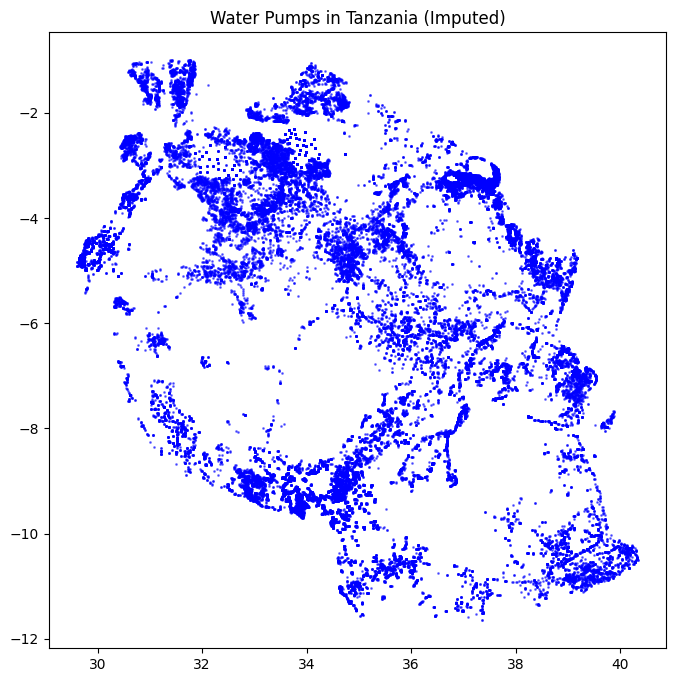

In [29]:
import matplotlib.pyplot as plt
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    df_final_fixed,
    geometry=gpd.points_from_xy(df_final_fixed.longitude, df_final_fixed.latitude),
    crs="EPSG:4326"
)

gdf.plot(figsize=(8, 8), markersize=1, color="blue", alpha=0.5)
plt.title("Water Pumps in Tanzania (Imputed)")
plt.show()


In [31]:
df_final_fixed = df_final_fixed.drop(['ward_clean','score','ward_clean_x','matched_ward', 'ward_clean_y', 'geometry'], axis=1) # 'ward_df_train','ward_df_gdf','score_x', 'score_y',
df_final_fixed.shape

(59400, 41)

In [ ]:
df_final_fixed.to_csv("../data/processed/lat_lon_imputed.csv", index=False)